# TTIC 31020 Introduction to Statistical Machine Learning: Neural Networks
---

In this notebook you will perform classification on the Fashion MNIST dataset with neural networks. Your task is (mostly) to implement the forward and backward methods for different layers (forward methods compute a layer's output given its input, while backward methods compute gradients for its parameters and its input given the gradient of its output).

After filling the missing code, try to achieve the best performance by changing the hyperparameters. Neural networks are typically more hyperparameter-sensitive than other methods you've seen in the past homeworks, so good hyperparameter tuning is crucial to get good results.

In [355]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from utils import *
import numpy as np
import math

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [356]:
# superclass of neural network "modules" (layers)
class Module:
    """
    Module is a super class. It could be a single layer, or a multilayer perceptron.
    """
    
    def __init__(self):
        self.train = True
        return
    
    def forward(self, _input):
        """
        z = f(a); a is the input, and h is the output.
        
        Inputs:
        _input: a
        
        Returns:
        output z
        """
        pass
    
    def backward(self, _input, _gradOutput):
        """
        Compute:
        gradient w.r.t. _input
        gradient w.r.t. trainable parameters
        
        Inputs (in lecture notation):
        _input: a 
        _gradOutput: dL/dz
        
        Returns:
        gradInput: dL/dz
        """
        pass
        
    def parameters(self):
        """
        Return the value of trainable parameters and its corresponding gradient (Used for grandient descent)
        
        Returns:
        params, gradParams
        """
        pass
    
    def training(self):
        """
        Turn the module into training mode.(Only useful for Dropout layer)
        Ignore it if you are not using Dropout.
        """
        self.train = True
        
    def evaluate(self):
        """
        Turn the module into evaluate mode.(Only useful for Dropout layer)
        Ignore it if you are not using Dropout.
        """
        self.train = False

In [357]:
# a class representing a sequence of modules (a layered network)
class Sequential(Module):
    """
    Sequential provides a way to plug layers together in a feed-forward manner.
    """
    def __init__(self):
        Module.__init__(self)
        self.layers = [] # layers contain all the layers in order
    
    def add(self, layer):
        self.layers.append(layer) # Add another layer at the end
    
    def size(self):
        return len(self.layers) # How many layers.
    
    def forward(self, _input):
        """
        Feed forward through all the layers, and return the output of the last layer
        """
        for i in range(self.size()):
            # The output of (i-1)-th layer is the _input of i-th layer
            _input = self.layers[i].forward(_input)
        self._output = _input
        return self._output
    
    def backward(self, _gradOutput):
        """
        Backpropagate through all the layers using chain rule.
        """
        for i in reversed(range(self.size())):
            # The (i-1)-th layer receives the error from the i-th layer
            _gradOutput = self.layers[i].backward(_gradOutput)
        return _gradOutput
    
    def parameters(self):
        """
        Return trainable parameters and its corresponding gradient in a list
        """
        params = []
        gradParams = []
        for m in self.layers:
            p, g = m.parameters()
            if p is not None:
                for _p, _g in zip(p,g):
                    params.append(_p)
                    gradParams.append(_g)
        return params, gradParams

    def training(self):
        """
        Turn all the layers into training mode
        """
        Module.training(self)
        for m in self.layers:
            m.training()
    
    def evaluate(self):
        """
        Turn all the layers into evaluate mode
        """
        Module.evaluate(self)
        for m in self.layers:
            m.evaluate()
        

In [358]:
def print_shape(x):
    print("print_shape: The shape is {}, {}".format(np.shape(x)[0], np.shape(x)[1]))

In [469]:
class FullyConnected(Module):
    """
    Fully connected layer (parameters include a matrix of weights a vector of biases)
    """
    def __init__(self, inputSize, outputSize):
        Module.__init__(self)
        
        # ADD CODE here to initialize the weights and biases
        # Use the Xavier scheme over here
        sigma = math.sqrt(1/inputSize)
        self.weight = np.random.normal(0, sigma, (outputSize, inputSize))
        self.bias = np.random.normal(0, sigma, outputSize)
        
        self.gradWeight = np.ndarray((inputSize, outputSize))
        self.gradBias = np.ndarray(outputSize)
        
    def forward(self, _input):
        """
        output = W * input + b
        """
        self._input = _input     

        # ADD CODE to compute the layer's output
        # The shape of the input is 8 * 10
        # The shape of the weight is 3 * 10
        # The shape of the bias is (8,)
        # print_shape(self.weight)
        # print_shape(self._input)
        # print(np.shape(self.bias))
        self._output =  np.matmul(self._input, self.weight.T)
            
        # self.weight, self._input.T).T
        # print_shape(self._output)
        # print("The shape is {}".format(np.shape(self.bias)[0]))
        for i in range(len(_input)):
            self._output[i] += self.bias
        return self._output
    
    def backward(self, _gradOutput):
        """
        gradWeight = gradOutput * input
        gradBias = gradOutput * vec(1)
        gradInput =  Weight * gradOutput
        Wight's shape is (outputSize, inputSize)
        """
        self.gradWeight.fill(0)
        self.gradBias.fill(0)

        # print_shape(_gradOutput)
        # print_shape(self._input)
        # print_shape(self.gradWeight)
        
        # ADD CODE to compute the gradient for the layer's weight
        #print_shape(self.gradWeight)
        self.gradWeight += np.dot(self._input.T, _gradOutput)
        #self.gradWeight += np.dot(_gradOutput.T, self._input)
    
        #print("the size of the _gradOutput is {}, {}".format(np.shape(_gradOutput)[0], np.shape(_gradOutput)[1]))
        # ADD CODE to compute the gradient for the layer's bias
        # print("The shape is {}".format(np.shape(self.gradBias)[0]))
        # print(np.shape(np.matmul(_gradOutput.T, np.ones(len(_gradOutput)))))
        #print_shape(self.gradBias)
        self.gradBias += np.matmul(_gradOutput.T, np.ones(len(_gradOutput)))
        # ADD CODE to compute the gradient for the layer's input
        #print_shape(self._gradInput)
        self._gradInput = np.dot(_gradOutput, self.weight)

        return self._gradInput
        
    def parameters(self):
        """
        Return weight and bias and their g
        """
        return [self.weight, self.bias], [self.gradWeight, self.gradBias]

In [470]:
class ReLU(Module):
    """
    ReLU activation, not trainable.
    """
    def __init__(self):
        Module.__init__(self)
        return
    
    def forward(self, _input):
        """
        output = max(0, input)
        """
        self._input = _input
        self._output = _input
        # ADD CODE to compute the layer's output
    
        # The input has size (3,10)
        # The output has size (3,10)
        for i in range(len(_input)):
            self._output[i] =  np.maximum(np.zeros(len(self._input[i])), self._input[i])
        return self._output
    
    def backward(self, _gradOutput):
        """
        gradInput = gradOutput * mask
        mask = _input > 0
        """
        # ADD CODE to compute the gradient for the layer's input
        # If input is 0, grad_Input is also 1
        # If input is not zero, grad_Input is _gradOutput
        self._gradInput = _gradOutput * (self._input > 0)
        return self._gradInput
        
    def parameters(self):
        """
        No trainable parametersm, return None
        """
        return None, None

In [471]:
class Dropout(Module):
    """
    A dropout layer
    """
    def __init__(self, p = 0.5):
        Module.__init__(self)
        self.p = p #self.p is the drop rate, if self.p is 0, then it's a identity layer
        
    def forward(self, _input):
        self._output = _input
        if self.p > 0:
            if self.train:
                # Randomize a mask from bernoulli distrubition
                self.mask = np.random.binomial(1, 1 - self.p, _input.shape).astype('float64')
                # Scale the mask
                self.mask /= 1 - self.p
                self._output *= self.mask
        return self._output
    
    def backward(self, _gradOutput):
        self._gradInput = _gradOutput
        if self.train:
            if self.p > 0:
                self._gradInput = self.mask* self._gradInput 
        return self._gradInput
    
    def parameters(self):
        """
        No trainable parameters.
        """
        return None, None

In [472]:
class SoftMaxLoss(object):
    def __init__(self):
        return
        
    def forward(self, _input, _label):
        """
        Softmax and cross entropy loss layer. Should return a scalar, since it's a
        loss. (It's almost identical to what we had in Pset 2)

        Inputs:
        _input: N x C
        _labels: N x C, one-hot

        Returns: loss (scalar)
        """
        self._input = _input - _input.max(1)[:, np.newaxis] # doing the adjustment for softmax
        # calculate log probability
        self._logprob = self._input - np.log(np.exp(self._input).sum(1)[:, np.newaxis])
        
        self._output = np.mean(np.sum(-self._logprob * _label, 1))
        return self._output
    
    def backward(self, _label):
        self._gradInput = (np.exp(self._logprob) - _label) / len(self._input) # ADD CODE to compute the gradient for the layer's input
        return self._gradInput

        

In [473]:
# Test softmaxloss, the relative error should be small enough
def test_sm():
    crit = SoftMaxLoss()
    gt = np.zeros((3, 10))
    gt[np.arange(3), np.array([1,2,3])] = 1
    x = np.random.random((3,10))
    def test_f(x):
        return crit.forward(x, gt)

    print(crit.forward(x, gt))
    gradInput = crit.backward(gt)
    gradInput_num = numeric_gradient(test_f, x, 1, 1e-6)
    print(relative_error(gradInput, gradInput_num, 1e-8))
    
test_sm()

2.4270368746847275
6.245556800592332e-09


In [474]:
# Test modules, all the relative errors should be small enough (on the order of 1e-6 or smaller)
def test_module(model):
    model.evaluate()

    crit = TestCriterion()
    gt = np.random.random((3,10))
    x = np.random.random((3,10))
    def test_f(x):
        return crit.forward(model.forward(x), gt)

    test_f(x)
    gradInput = model.backward(crit.backward(gt))
    gradInput_num = numeric_gradient(test_f, x, 1, 1e-6)
    print(relative_error(gradInput, gradInput_num, 1e-8))

# Test fully connected
model = FullyConnected(10, 8)
print('testing FullyConnected')
test_module(model)

# Test ReLU
model = ReLU()
print('testing ReLU')
test_module(model)

# Test Dropout
model = Dropout()
print('testing Dropout')
test_module(model)


testing FullyConnected
4.919703731261059e-09
testing ReLU
7.360228254783035e-10
testing Dropout
5.962448038856628e-10


In [475]:
model = Sequential()
#ADD CODE to add layers using the add attribute of sequential 
#to construct 2-layer Neural Network with hidden size 10

layer_one = FullyConnected(10, 10)
model.add(layer_one)
model.add(ReLU())
layer_two = FullyConnected(10, 10)
model.add(layer_two)


In [476]:
# Test your neural network
print('testing 2-layer model')
test_module(model)

testing 2-layer model
7.855736459777633e-08


In [477]:
def sgd(x, dx, lr, weight_decay = 0):
    #ADD CODE to perform one gradient descent step
    for i in range(len(x)):
        if ((i % 2) == 0):
            x[i] -= lr * (dx[i].T + 2 * weight_decay * x[i]) 
        else:
            x[i] -= lr * (dx[i].T)
        

In [478]:
# Test gradient descent, the loss should be lower and lower
trainX = np.random.random((10,10))

crit = TestCriterion()

params, gradParams = model.parameters()

it = 0
state = None
while True:
    output = model.forward(trainX)
    loss = crit.forward(output, None)
    if it % 100 == 0:
        print(loss)
    doutput = crit.backward(None)
    model.backward(doutput)
    # print(np.shape(params))
    # print(np.shape(gradParams))

    sgd(params, gradParams, 0.01)
    if it > 1000:
        break
    it += 1

3.154806692439288
0.3620601236660053
0.24197890475411726
0.22145627006487606
0.1556062346147803
0.17418336554494032
0.15036445411096092
0.15084613175289693
0.1545282318142583
0.09557576715686501
0.0966292867312172


Now we start to work on Fashion MNIST.

In [479]:
import FMNIST_utils

# We only consider large set this time
print("Load large trainset.")
Xlarge,Ylarge = FMNIST_utils.load_data("Tr")
print(Xlarge.shape)
print(Ylarge.shape)
if Xlarge.max() > 1: Xlarge = Xlarge/255

print("Load valset.")
Xval,Yval = FMNIST_utils.load_data("Vl")
print(Xval.shape)
print(Yval.shape)
if Xval.max() > 1: Xval = Xval/255

Load large trainset.
(50000, 784)
(50000, 10)
Load valset.
(5000, 784)
(5000, 10)


In [486]:
def predict(X, model):
    """
    Evaluate the soft predictions of the model.
    Input:
    X : N x d array (no unit terms)
    model : a multi-layer perceptron
    Output:
    yhat : N x C array
        yhat[n][:] contains the score over C classes for X[n][:]
    """
    return model.forward(X)

def error_rate(X, Y, model):
    """
    Compute error rate (between 0 and 1) for the model
    """
    model.evaluate()
    res = 1 - (model.forward(X).argmax(-1) == Y.argmax(-1)).mean()
    model.training()
    return res

from copy import deepcopy

def runTrainVal(X,Y,model,Xval,Yval,trainopt):
    """
    Run the train + evaluation on a given train/val partition
    trainopt: various (hyper)parameters of the training procedure
    During training, choose the model with the lowest validation error. (early stopping)
    Assumes (global) variable crit containing the loss (training "criterion" to be minimized)
    """
    
    params, gradParams = model.parameters()
    
    eta = trainopt['eta']
    
    N = X.shape[0] # number of data points in X
    
    # Save the model with lowest validation error
    minValError = np.inf
    saved_model = None # Save the best model accoring to validation error
    
    shuffled_idx = np.random.permutation(N)
    start_idx = 0
    for iteration in range(trainopt['maxiter']):
        if iteration % int(trainopt['eta_frac'] * trainopt['maxiter']) == 0:
            eta *= trainopt['etadrop']
        # form the next mini-batch
        stop_idx = min(start_idx + trainopt['batch_size'], N)
        batch_idx = range(N)[int(start_idx):int(stop_idx)]
        
        s_idx = shuffled_idx[batch_idx]
        
        bX = X[s_idx,:]
        bY = Y[s_idx,:]

        score = model.forward(bX)
        loss = crit.forward(score, bY)
        # note: this computes loss on the *batch* only, not on the entire training set!
        
        dscore = crit.backward(bY)
        model.backward(dscore)
        
        sgd(params, gradParams, eta, weight_decay = trainopt['lambda'])

        start_idx = stop_idx % N
        
        if (iteration % trainopt['display_iter']) == 0:
            #compute train and val error; multiply by 100 for readability (make it percentage points)
            trainError = 100 * error_rate(X, Y, model)
            valError = 100 * error_rate(Xval, Yval, model)
            print('{:8} batch loss: {:.3f} train error: {:.3f} val error: {:.3f}'.format(iteration, loss, trainError, valError))
            
            # early stopping: save the best model snapshot so far (i.e., model with lowest val error)
            if valError < minValError:
                saved_model = deepcopy(model)
                minValError = valError
        
    return saved_model, minValError, trainError, loss

In [487]:
def build_model(input_size, hidden_size, output_size, activation_func = 'ReLU', dropout = 0):
    """
    Build a 2-layer model:
    input_size: the dimension of input data
    hidden_size: the dimension of hidden vector, hidden_size == 0 means only one layer
    output_size: the output size of final layer.
    activation_func: ReLU, sigmoid (defined above), Tanh (you'd have to define), etc. 
    dropout: the dropout rate: if dropout == 0, this is equivalent to no dropout
    """
    model = Sequential()
    
    if type(hidden_size) is int:
        hidden_size = [hidden_size] # ensure it's a list
    
    prev_size=input_size
    
    # add hidden layer(s) as requested
    if hidden_size[0] == 0: # no hidden layer
        pass
    
    else:
        for l in range(len(hidden_size)):
            # ADD CODE to add a fully connected layer 
            each_layer = FullyConnected(prev_size, hidden_size[l])
            model.add(each_layer)
            
            prev_size=hidden_size[l]
            # ADD CODE to add a Relu
            relu_layer = ReLU()
            model.add(relu_layer)
            
            if dropout > 0:
                #ADD CODE to add Dropout 
                dropout_layer = Dropout(dropout)
                model.add(dropout_layer)
                     
                
    # ADD CODE to add output layer  (which is a fully connected layer)
    output_layer = FullyConnected(hidden_size[-1], output_size)
    model.add(output_layer)
    
    return model

In [488]:
trainopt = {
    'eta': 1e-3,   # initial learning rate
    'maxiter': 10000,   # max number of iterations (updates) of SGD
    'display_iter': 1000,  # display batch loss every display_iter updates, originally 5000
    'batch_size': 128,  
    'etadrop': .5, # when dropping eta, multiply it by this number (e.g., .5 means halve it)
    'eta_frac': .25,  # drop eta after every eta_frac*maxiter
    'update': 'sgd'
}
NFEATURES = Xlarge.shape[1]

# we will maintain a record of models trained for different values of lambda
# these will be indexed directly by lambda value itself
trained_models = dict()

# choose the set of hyperparameters to explore

lambda_=0.0

hidden_size_=[2000] # ADD CODE to specify hidden dim for each layer; 
trainopt['lambda'] = lambda_
model = build_model(NFEATURES, hidden_size_, 10, dropout = 0.1) 
crit = SoftMaxLoss()
# -- model trained on large train set
trained_model,valErr,trainErr = runTrainVal(Xlarge, Ylarge, model, Xval, Yval, trainopt)
trained_models[lambda_] = {'model': trained_model, "val_err": valErr, "train_err": trainErr }
print('train set model [ h = ',end='')
for l in range(len(hidden_size_)):
    print('%d '%hidden_size_[l],end='')
print(' ], lambda= %.4f ] --> train error: %.2f, val error: %.2f' % (lambda_, trainErr, valErr))


       0 batch loss: 2.349 train error: 91.022 val error: 90.740


KeyboardInterrupt: 

In [491]:
h_lst = [20, 200, 1000]
dropout_lst = [0.1, 0.5]
lambda_lst = [0.01, 0.03, 0.05]
best_loss = None
best_h = 0
best_dropout_rate = 0
best_lambda = 0


for h in h_lst:
    for d in dropout_lst:
        for l in lambda_lst:
            trainopt = {
                'eta': 1e-3,   # initial learning rate
                'maxiter': 10000,   # max number of iterations (updates) of SGD
                'display_iter': 1000,  # display batch loss every display_iter updates, originally 5000
                'batch_size': 128,  
                'etadrop': .5, # when dropping eta, multiply it by this number (e.g., .5 means halve it)
                'eta_frac': .25,  # drop eta after every eta_frac*maxiter
                'update': 'sgd'
            }
            NFEATURES = Xlarge.shape[1]

            # we will maintain a record of models trained for different values of lambda
            # these will be indexed directly by lambda value itself
            trained_models = dict()

            # choose the set of hyperparameters to explore

            lambda_= l
            hidden_size_=[h] # ADD CODE to specify hidden dim for each layer; 
            trainopt['lambda'] = lambda_
            model = build_model(NFEATURES, hidden_size_, 10, dropout = d) 
            crit = SoftMaxLoss()
            # -- model trained on large train set
            trained_model,valErr,trainErr, loss = runTrainVal(Xlarge, Ylarge, model, Xval, Yval, trainopt)
            trained_models[lambda_] = {'model': trained_model, "val_err": valErr, "train_err": trainErr, 'loss': loss }
            print('train set model [ h = ',end='')
            for l in range(len(hidden_size_)):
                print('%d '%hidden_size_[l],end='')
            print(' ], lambda= %.4f ] --> train error: %.2f, val error: %.2f' % (lambda_, trainErr, valErr))
            if best_loss == None:
                best_loss = loss
                best_lambda = l
                best_h = h
                best_dropout_rate = d
            else:
                if (best_loss > loss):
                    best_loss = loss
                    best_lambda = l
                    best_h = h
                    best_dropout_rate = d
print("best Loss is{}, best lambda is {}, best dropout rate is {}, best hidden size is{}".format(best_loss, best_lambda, best_h, best_dropout_rate))

       0 batch loss: 2.347 train error: 92.692 val error: 92.440
    1000 batch loss: 2.028 train error: 60.988 val error: 61.560
    2000 batch loss: 1.728 train error: 49.572 val error: 50.500
    3000 batch loss: 1.561 train error: 44.352 val error: 44.620
    4000 batch loss: 1.461 train error: 38.208 val error: 38.520
    5000 batch loss: 1.391 train error: 36.428 val error: 36.640
    6000 batch loss: 1.457 train error: 36.142 val error: 36.180
    7000 batch loss: 1.501 train error: 35.856 val error: 35.580
    8000 batch loss: 1.487 train error: 35.784 val error: 35.540
    9000 batch loss: 1.349 train error: 35.686 val error: 35.420
train set model [ h = 20  ], lambda= 0.0100 ] --> train error: 35.69, val error: 35.42
       0 batch loss: 2.423 train error: 89.880 val error: 89.640
    1000 batch loss: 1.995 train error: 73.800 val error: 75.240
    2000 batch loss: 1.905 train error: 54.552 val error: 54.900
    3000 batch loss: 1.627 train error: 42.248 val error: 42.100
   

In [494]:
h_lst = [20, 200, 1000, 2000, 3000]
l = 0.03
d = 0.1 
loss_lst = []
val_error_lst = []
train_error_lst = []

for h in h_lst:
    trainopt = {
        'eta': 1e-3,   # initial learning rate
        'maxiter': 10000,   # max number of iterations (updates) of SGD
        'display_iter': 1000,  # display batch loss every display_iter updates, originally 5000
        'batch_size': 128,  
        'etadrop': .5, # when dropping eta, multiply it by this number (e.g., .5 means halve it)
        'eta_frac': 0.5,  # drop eta after every eta_frac*maxiter
        'update': 'sgd'
    }
    NFEATURES = Xlarge.shape[1]

    # we will maintain a record of models trained for different values of lambda
    # these will be indexed directly by lambda value itself
    trained_models = dict()

    # choose the set of hyperparameters to explore

    lambda_= l
    hidden_size_=[h] # ADD CODE to specify hidden dim for each layer; 
    trainopt['lambda'] = lambda_
    model = build_model(NFEATURES, hidden_size_, 10, dropout = d) 
    crit = SoftMaxLoss()
    # -- model trained on large train set
    trained_model,valErr,trainErr, loss = runTrainVal(Xlarge, Ylarge, model, Xval, Yval, trainopt)
    trained_models[lambda_] = {'model': trained_model, "val_err": valErr, "train_err": trainErr, 'loss': loss }
    print('train set model [ h = ',end='')
    for l in range(len(hidden_size_)):
        print('%d '%hidden_size_[l],end='')
    print(' ], lambda= %.4f ] --> train error: %.2f, val error: %.2f' % (lambda_, trainErr, valErr))
    if best_loss == None:
        best_loss = loss
        best_lambda = l
        best_h = h
        best_dropout_rate = d
    else:
        if (best_loss > loss):
            best_loss = loss
            best_lambda = l
            best_h = h
            best_dropout_rate = d
    loss_lst.append(loss)
    train_error_lst.append(trainErr)
    val_error_lst.append(valErr)
print("best Loss is{}, best lambda is {}, best dropout rate is {}, best hidden size is{}".format(best_loss, best_lambda, best_dropout_rate, best_h))


       0 batch loss: 2.344 train error: 86.194 val error: 85.840
    1000 batch loss: 1.942 train error: 63.408 val error: 63.420
    2000 batch loss: 1.770 train error: 49.844 val error: 50.100
    3000 batch loss: 1.599 train error: 36.684 val error: 36.840
    4000 batch loss: 1.438 train error: 33.104 val error: 33.220
    5000 batch loss: 1.327 train error: 31.718 val error: 31.760
    6000 batch loss: 1.344 train error: 31.346 val error: 31.340
    7000 batch loss: 1.304 train error: 30.764 val error: 30.780
    8000 batch loss: 1.238 train error: 30.356 val error: 30.300
    9000 batch loss: 1.252 train error: 29.994 val error: 29.900
train set model [ h = 20  ], lambda= 0.0300 ] --> train error: 29.99, val error: 29.90
       0 batch loss: 2.406 train error: 89.922 val error: 89.120
    1000 batch loss: 1.773 train error: 43.752 val error: 44.300
    2000 batch loss: 1.482 train error: 34.894 val error: 34.960
    3000 batch loss: 1.221 train error: 32.546 val error: 32.640
   

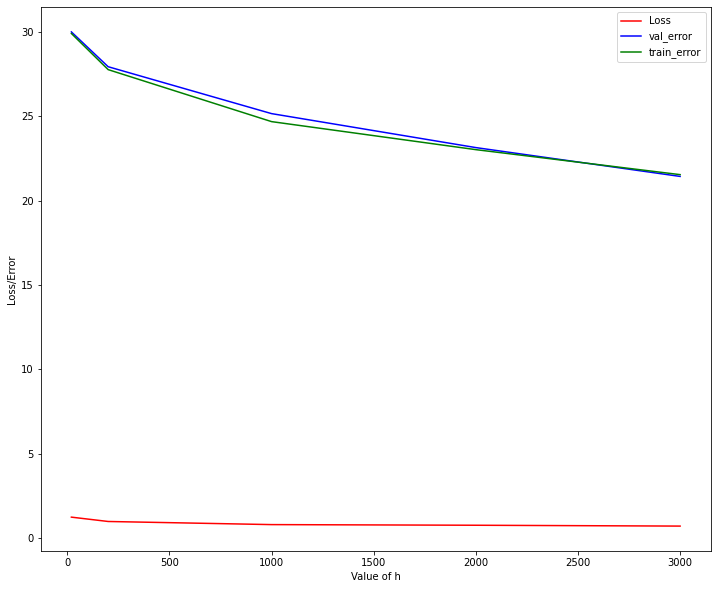

In [503]:
import matplotlib.pyplot as plt

h = [20, 200, 1000, 2000, 3000]
fig, axs = plt.subplots(1, 1, figsize=(12,10))

loss_lst = [1.252, 0.995, 0.810, 0.772, 0.722]
val_error_lst = [29.994, 27.932, 25.154, 23.142, 21.434]
train_error_lst = [29.900, 27.760, 24.680, 23.020, 21.540]



axs.plot(h, loss_lst, color = 'red', label = 'Loss')
axs.plot(h, val_error_lst, color = 'blue', label = 'val_error')
axs.plot(h, train_error_lst, color = 'green', label = 'train_error')

plt.xlabel("Value of h")
plt.ylabel("Loss/Error")

axs.legend()
plt.show()

The best parameter for a two-layer network is  best lambda is 0.03, best dropout rate is 0.1, 
best hidden size is 3000. The lowest loss is 0.722, the best train error is 21.434 
the best val error is 21.540.

In [492]:
dropout_lst = [0.1, 0.5]
lambda_lst = [0.01, 0.03]
hidden_one = [200, 80]
hidden_two = [200, 50]
hidden_three = [500, 80]
hidden_four = [500, 50]
h_lst = [hidden_one, hidden_two, hidden_three, hidden_four]

best_loss = None
best_h = 0
best_dropout_rate = 0
best_lambda = 0


for h in h_lst:
    for d in dropout_lst:
        for l in lambda_lst:
            trainopt = {
                'eta': 1e-3,   # initial learning rate
                'maxiter': 10000,   # max number of iterations (updates) of SGD
                'display_iter': 1000,  # display batch loss every display_iter updates, originally 5000
                'batch_size': 128,  
                'etadrop': .5, # when dropping eta, multiply it by this number (e.g., .5 means halve it)
                'eta_frac': .25,  # drop eta after every eta_frac*maxiter
                'update': 'sgd'
            }
            NFEATURES = Xlarge.shape[1]

            # we will maintain a record of models trained for different values of lambda
            # these will be indexed directly by lambda value itself
            trained_models = dict()

            # choose the set of hyperparameters to explore
            lambda_= l
            hidden_size_=h # ADD CODE to specify hidden dim for each layer; 
            trainopt['lambda'] = lambda_
            model = build_model(NFEATURES, hidden_size_, 10, dropout = d) 
            crit = SoftMaxLoss()
            # -- model trained on large train set
            trained_model,valErr,trainErr, loss = runTrainVal(Xlarge, Ylarge, model, Xval, Yval, trainopt)
            trained_models[lambda_] = {'model': trained_model, "val_err": valErr, "train_err": trainErr, 'loss': loss }
            print('train set model [ h = ',end='')
            for l in range(len(hidden_size_)):
                print('%d '%hidden_size_[l],end='')
            print(' ], lambda= %.4f ] --> train error: %.2f, val error: %.2f' % (lambda_, trainErr, valErr))
            if best_loss == None:
                best_loss = loss
                best_lambda = l
                best_h = h
                best_dropout_rate = d
            else:
                if (best_loss > loss):
                    best_loss = loss
                    best_lambda = l
                    best_h = h
                    best_dropout_rate = d
print("best Loss is{}, best lambda is {}, best dropout rate is {}, best hidden size is{}".format(best_loss, best_lambda, best_h, best_dropout_rate))
            

       0 batch loss: 2.298 train error: 86.430 val error: 86.440
    1000 batch loss: 1.988 train error: 57.260 val error: 57.360
    2000 batch loss: 1.799 train error: 46.136 val error: 46.440
    3000 batch loss: 1.567 train error: 40.000 val error: 40.520
    4000 batch loss: 1.452 train error: 37.308 val error: 37.480
    5000 batch loss: 1.364 train error: 35.640 val error: 35.980
    6000 batch loss: 1.268 train error: 35.154 val error: 35.460
    7000 batch loss: 1.291 train error: 34.704 val error: 35.020
    8000 batch loss: 1.303 train error: 34.496 val error: 34.700
    9000 batch loss: 1.221 train error: 34.346 val error: 34.520
train set model [ h = 200 80  ], lambda= 0.0100 ] --> train error: 34.35, val error: 34.52
       0 batch loss: 2.459 train error: 92.504 val error: 91.920
    1000 batch loss: 1.991 train error: 53.796 val error: 54.120
    2000 batch loss: 1.677 train error: 43.688 val error: 43.900
    3000 batch loss: 1.564 train error: 38.408 val error: 38.380

In [498]:
h = [3000, 800]
l = 0.03
d = 0.1 
loss_lst = []
val_error_lst = []
train_error_lst = []

best_loss = None
best_h = 0
best_dropout_rate = 0
best_lambda = 0

trainopt = {
    'eta': 1e-3,   # initial learning rate
    'maxiter': 10000,   # max number of iterations (updates) of SGD
    'display_iter': 1000,  # display batch loss every display_iter updates, originally 5000
    'batch_size': 128,  
    'etadrop': .5, # when dropping eta, multiply it by this number (e.g., .5 means halve it)
    'eta_frac': .25,  # drop eta after every eta_frac*maxiter
    'update': 'sgd'
}
NFEATURES = Xlarge.shape[1]

# we will maintain a record of models trained for different values of lambda
# these will be indexed directly by lambda value itself
trained_models = dict()


# choose the set of hyperparameters to explore
lambda_= l
hidden_size_=h # ADD CODE to specify hidden dim for each layer; 
trainopt['lambda'] = lambda_
model = build_model(NFEATURES, hidden_size_, 10, dropout = d) 
crit = SoftMaxLoss()
# -- model trained on large train set
trained_model,valErr,trainErr, loss = runTrainVal(Xlarge, Ylarge, model, Xval, Yval, trainopt)
trained_models[lambda_] = {'model': trained_model, "val_err": valErr, "train_err": trainErr, 'loss': loss }
print('train set model [ h = ',end='')
for l in range(len(hidden_size_)):
    print('%d '%hidden_size_[l],end='')
print(' ], lambda= %.4f ] --> train error: %.2f, val error: %.2f' % (lambda_, trainErr, valErr))
if best_loss == None:
    best_loss = loss
    best_lambda = l
    best_h = h
    best_dropout_rate = d
else:
    if (best_loss > loss):
        best_loss = loss
        best_lambda = l
        best_h = h
        best_dropout_rate = d
print("best Loss is{}, best lambda is {}, best dropout rate is {}, best hidden size is{}".format(best_loss, best_lambda, best_h, best_dropout_rate))

       0 batch loss: 2.373 train error: 86.986 val error: 86.980
    1000 batch loss: 1.496 train error: 34.278 val error: 34.720
    2000 batch loss: 1.179 train error: 32.820 val error: 32.360
    3000 batch loss: 1.053 train error: 31.194 val error: 30.480
    4000 batch loss: 0.973 train error: 30.092 val error: 29.200
    5000 batch loss: 0.955 train error: 29.296 val error: 28.480
    6000 batch loss: 0.985 train error: 28.728 val error: 27.980
    7000 batch loss: 0.969 train error: 28.426 val error: 27.880
    8000 batch loss: 0.921 train error: 28.036 val error: 27.560
    9000 batch loss: 0.972 train error: 27.912 val error: 27.340
train set model [ h = 3000 800  ], lambda= 0.0300 ] --> train error: 27.91, val error: 27.34
best Loss is0.9532290671308266, best lambda is 1, best dropout rate is [3000, 800], best hidden size is0.1


The best lambda is 0.03. The best droput rate is 0.1. The best hidden size is 
[3000, 800]. The best loss is 0.953. The best train error is 27.91,
the best val error: 27.34.

In [ ]:
#Generate a Kaggle submission file using best_trained_model which you should set based on your experiments
kaggleX = FMNIST_utils.load_data('kaggle')
if kaggleX.max() > 1: kaggleX = kaggleX/255
kaggleYhat = predict(kaggleX, trained_model).argmax(-1)
save_submission('submission-fmnist.csv', kaggleYhat)